## IMPORTS

In [51]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
from glob import glob


sys.path.append('../../')
from utils import clustering_utils, bokeh_ui_utils, file_utils

In [52]:
full_filtered_df = pd.read_csv('../../active_fastas/rna_seq.csv')
full_filtered_norm_df = full_filtered_df

num_genes = full_filtered_df.shape[0]
num_genes

21524

In [53]:
full_filtered_df.sample(10)

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
13423,TTHERM_00318820,-0.060835,-0.102477,-0.733421,-1.602055,-0.734184,-0.239378,1.550144,1.680338,0.241868
5583,YF00008246.t1,2.596704,0.162803,0.030566,-0.882503,0.175301,-0.033235,-0.594015,-0.669623,-0.785999
5907,TTHERM_00101460,0.896031,0.526433,0.735108,0.406559,0.296385,1.094958,-0.645632,-1.526135,-1.783709
2772,YF00004120.t1,0.069117,0.218219,-0.173129,0.324989,0.386827,-1.492592,-1.492592,0.111145,2.048015
21242,TTHERM_00486330,-0.067978,0.047556,0.467636,0.966410,1.116773,1.126132,-0.477863,-1.439641,-1.739026
13406,TTHERM_01004990,-1.960923,0.476884,1.029200,1.133646,1.011462,0.249457,-0.983360,-0.669700,-0.286668
7282,YF00011233.t1,2.097952,0.805667,-0.040638,-0.291541,0.509684,0.132544,-1.253213,-1.196178,-0.764278
1200,TTHERM_00294730,-0.779383,-0.926457,-1.729490,-0.549593,0.347007,0.306248,0.669818,1.464101,1.197749
21363,YF00037860.t1,2.033419,0.766161,1.158579,-0.198499,-0.804410,-0.724429,-0.644698,-0.952898,-0.633224
4463,TTHERM_00470890,-1.386808,-0.917831,-1.501315,0.141015,1.161903,1.061113,0.515062,1.091806,-0.164946


In [54]:
cycle_expression_conflict_df = full_filtered_df.loc[
    (full_filtered_df['000min'] > 0.9)
    &
    (full_filtered_df['210min'] < 0.1)
    &
    (full_filtered_df['240min'] < 0.1)
]

In [55]:
cycle_expression_conflict_df

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,TTHERM_00161861,0.910193,-0.286020,-0.119706,0.893590,0.928947,0.176211,0.727746,-1.052564,-2.178396
6,TTHERM_000161789,2.261305,0.620949,-1.042034,-1.259590,0.252273,-0.102887,0.330185,-0.734130,-0.326072
8,TTHERM_00161780,0.935421,0.699402,-0.142884,0.016602,0.136700,1.443761,0.185203,-1.394728,-1.879477
16,TTHERM_00161690,1.351731,0.149180,0.587951,-1.639571,-0.157602,1.150480,0.598685,-0.615899,-1.424954
18,TTHERM_00161670,2.259856,-0.422235,-0.963075,-0.670578,0.600565,0.554869,0.164753,-0.271998,-1.252156
...,...,...,...,...,...,...,...,...,...,...
21513,YF00038363.t1,2.481030,0.516379,-0.101797,-0.486988,-0.813020,0.099809,0.032080,-1.152030,-0.575464
21515,YF00038368.t1,1.369232,-0.645802,-1.089678,-0.064023,0.125732,2.039101,-0.137823,-0.955091,-0.641647
21518,TTHERM_01068130,1.034074,0.597451,-1.152814,-1.240039,-0.707393,1.968434,0.126318,-0.557980,-0.068052
21521,YF00038377.t1,2.725986,-0.627384,-0.813547,-0.394835,-0.480004,-0.116765,0.062185,-0.025355,-0.330281


In [56]:
cycle_expression_conflict_df.to_csv('./cycle_expression_conflict.csv')

### LEIDEN CLUSTERING

In [57]:
phases = 'rna_seq'

In [58]:
metric = 'manhattan'
# metric='minkowski_3.0'

# resolution_param=0.050
resolution_param=0.025

n_neighbors = 3

In [59]:
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_df, 
    metric=metric, 
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [60]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./rna_seq_label_df_round_1.csv', index=False)

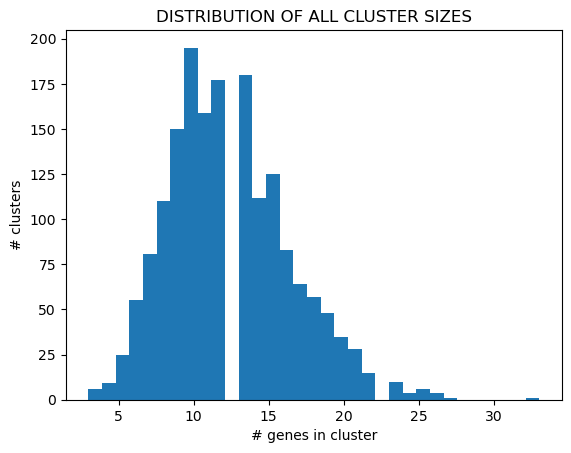

In [61]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

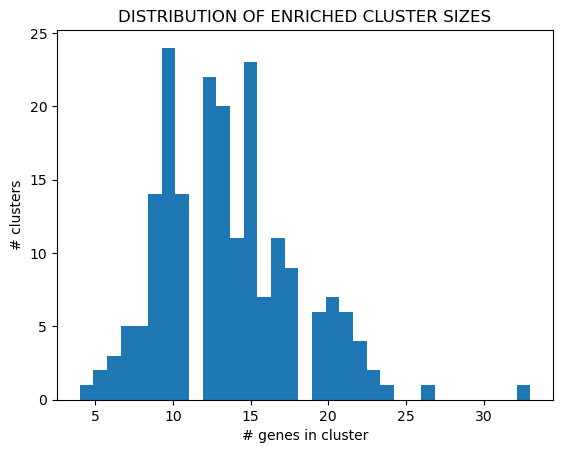

In [62]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [63]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.025
            silhouette_score: -0.0076220082468649135
                  modularity: 0.7532360774161144
                   nclusters: 1740
           mean_cluster_size: 12.370114942528735
         median_cluster_size: 12.0
             sd_cluster_size: 4.113731280025408
          nenriched_clusters: 199
  mean_enriched_cluster_size: 13.608040201005025
median_enriched_cluster_size: 13.0
    sd_enriched_cluster_size: 4.386724568581316
     nenriched_cluster_genes: 2708
                    datetime: 2024-04-26 10:47:07.717767


In [64]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [65]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [66]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [67]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [68]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [69]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [70]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [71]:
import os

embedding_metric = 'manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors)

/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard254_rna_seq_umap_manhattan_3nn_0.025rp.html


In [72]:
df_y_to_ttherm = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_feb2024.csv')
dict_y_to_ttherm = {yf: ttherm for yf, ttherm in zip(df_y_to_ttherm['yf2024'].values, df_y_to_ttherm['ttherm2021'].values)}
dict_ttherm_to_y = {ttherm: yf for yf, ttherm in zip(df_y_to_ttherm['yf2024'].values, df_y_to_ttherm['ttherm2021'].values)}

In [73]:
leiden_label_df_round_1_arranged_sorted

,TTHERM_ID,label
18765,YF00029644.t1,1739
13901,YF00021589.t1,1739
11152,YF00017429.t1,1739
9253,YF00014375.t1,1739
3694,YF00005471.t1,1739
...,...,...
8104,TTHERM_00627070,0
20424,TTHERM_00561420,0
15609,TTHERM_00456840,0
5179,TTHERM_00395880,0


In [74]:
xls_files = glob('../../new_raw_data/rna_seq_processed/xls_files/*.xls')
sorted(xls_files)

['../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s01.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s02.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s03.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s04.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s05.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s06.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s07.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s08.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s09.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s10.xls']

In [76]:
for xls_file in xls_files:
    excel_file = pd.read_excel(xls_file, sheet_name=None)
    for sheet_name, df in excel_file.items():
        target_ids = []
        gene_cluster_assignments_mode_only = None

        first_column = df.iloc[:, 0].values
        
        for gene in first_column:
            if gene in dict_ttherm_to_y:
                target_ids.append(f'{dict_ttherm_to_y[gene]}.t1')

            # ACCOUNT FOR TRANSLATE YF TO TTHERM BEING ENABLED
            if gene in leiden_label_df_round_1_arranged_sorted['TTHERM_ID'].values:
                target_ids.append(gene)

        gene_cluster_assignments = leiden_label_df_round_1_arranged_sorted.loc[leiden_label_df_round_1_arranged_sorted['TTHERM_ID'].isin(target_ids)]

        if gene_cluster_assignments.shape[0] > 0:
            cluster_assignment_mode = gene_cluster_assignments['label'].mode()[0]
            gene_cluster_assignments_mode_only = gene_cluster_assignments.loc[gene_cluster_assignments['label'] == cluster_assignment_mode]
        
            print(sheet_name, '|',
                    gene_cluster_assignments_mode_only.shape[0], '/', gene_cluster_assignments.shape[0], '=',
                    gene_cluster_assignments_mode_only.shape[0]/gene_cluster_assignments.shape[0]
                    )
            print(gene_cluster_assignments_mode_only)
            print(','.join(list(gene_cluster_assignments_mode_only['TTHERM_ID'].values)))

        else:
            print(sheet_name)
            print(gene_cluster_assignments)

        # print(gene_cluster_assignments)

        print()
        print()
        print()

genes | 7 / 58 = 0.1206896551724138
              TTHERM_ID  label
14187   TTHERM_01251290    294
12843   TTHERM_00571820    294
13065   TTHERM_00373820    294
520     TTHERM_00300320    294
19      TTHERM_00161640    294
8438    TTHERM_00134880    294
15311  TTHERM_000384969    294
TTHERM_01251290,TTHERM_00571820,TTHERM_00373820,TTHERM_00300320,TTHERM_00161640,TTHERM_00134880,TTHERM_000384969



named_genes | 3 / 11 = 0.2727272727272727
             TTHERM_ID  label
13717  TTHERM_00540340    928
14318  TTHERM_00118700    928
17490  TTHERM_00079520    928
TTHERM_00540340,TTHERM_00118700,TTHERM_00079520



mitotic cell cycle process | 3 / 5 = 0.6
             TTHERM_ID  label
13717  TTHERM_00540340    928
14318  TTHERM_00118700    928
17490  TTHERM_00079520    928
TTHERM_00540340,TTHERM_00118700,TTHERM_00079520



mitotic_nuclear_division | 3 / 5 = 0.6
             TTHERM_ID  label
13717  TTHERM_00540340    928
14318  TTHERM_00118700    928
17490  TTHERM_00079520    928
TTHERM_00540340,